## Taking all images from the 3 classes and using transfer learning using efficientNet model.
### Using all the images for initial training

Processing images: 100%|██████████| 17717/17717 [08:40<00:00, 34.04it/s]


Number of images per class:
Infiltration: 9547
Atelectasis: 4215
Effusion: 3955
Found 14174 images belonging to 3 classes.
Found 3543 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 14174
Number of validation samples: 3543
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


443/443 ━━━━━━━━━━━━━━━━━━━━ 356s 649ms/step - accuracy: 0.4513 - loss: 1.0810 - val_accuracy: 0.2393 - val_loss: 1.2362
Epoch 2/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 247s 550ms/step - accuracy: 0.5192 - loss: 1.0065 - val_accuracy: 0.5430 - val_loss: 0.9645
Epoch 3/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 245s 546ms/step - accuracy: 0.5616 - loss: 0.9444 - val_accuracy: 0.5803 - val_loss: 0.9112
Epoch 4/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 244s 543ms/step - accuracy: 0.5710 - loss: 0.9200 - val_accuracy: 0.6063 - val_loss: 0.8777
Epoch 5/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 246s 547ms/step - accuracy: 0.5945 - loss: 0.8833 - val_accuracy: 0.6122 - val_loss: 0.8614
Epoch 6/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 245s 545ms/step - accuracy: 0.6097 - loss: 0.8708 - val_accuracy: 0.6238 - val_loss: 0.8433
Epoch 7/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 245s 546ms/step - accuracy: 0.6246 - loss: 0.8357 - val_accuracy: 0.6269 - val_loss: 0.8295
Epoch 8/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 245s 546ms/step - accuracy: 0.6375 - loss: 0.81

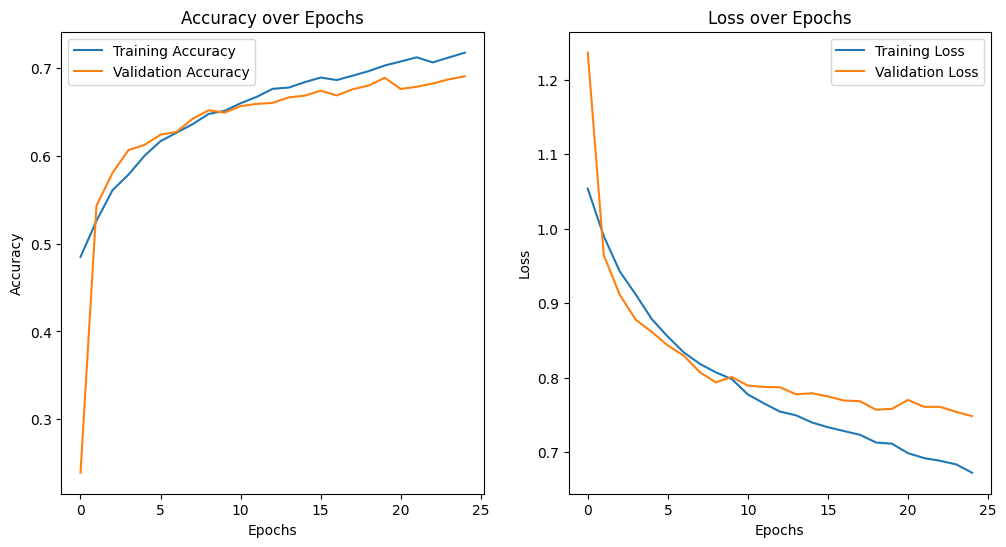

In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set paths
data_entry_path = "/kaggle/input/data/Data_Entry_2017.csv"
weights_path = "/kaggle/input/efficientnet/tensorflow2/default/1/efficientnetb0_notop (1).h5"

# Load the data entry file
data_entry = pd.read_csv(data_entry_path)

# Specify the diseases
selected_diseases = ['Infiltration', 'Atelectasis', 'Effusion']
data_entry = data_entry[data_entry['Finding Labels'].apply(lambda x: x in selected_diseases)]
data_entry['label'] = data_entry['Finding Labels']

# List of image folder paths
image_paths = [
    '/kaggle/input/data/images_001/images',
    '/kaggle/input/data/images_002/images',
    '/kaggle/input/data/images_003/images',
    '/kaggle/input/data/images_004/images',
    '/kaggle/input/data/images_005/images',
    '/kaggle/input/data/images_006/images',
    '/kaggle/input/data/images_007/images',
    '/kaggle/input/data/images_008/images',
    '/kaggle/input/data/images_009/images',
    '/kaggle/input/data/images_010/images',
    '/kaggle/input/data/images_011/images',
    '/kaggle/input/data/images_012/images',
]

# Collect all image paths
all_image_paths = []
for path in image_paths:
    all_image_paths.extend(glob.glob(f"{path}/*.png"))

# Map image names to their full paths
image_path_dict = {os.path.basename(image): image for image in all_image_paths}

# Add the image path to the DataFrame
data_entry['path'] = data_entry['Image Index'].map(image_path_dict.get)
data_entry = data_entry.dropna(subset=['path'])  # Remove rows where no matching image was found

# Preprocess images
def preprocess_image(image_path, target_size=(256, 256)):
    try:
        image = cv2.imread(image_path)
        if image is None or len(image.shape) != 3 or image.shape[2] != 3:
            return None
        image = cv2.resize(image, target_size)
        image = image / 255.0
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Prepare directory for processed images
filtered_image_dir = "processed_images"
os.makedirs(filtered_image_dir, exist_ok=True)

# Dictionary to keep track of the image count for each class
class_counts = {disease: 0 for disease in selected_diseases}

# Process and save all images, and count them
for _, row in tqdm(data_entry.iterrows(), desc="Processing images", total=data_entry.shape[0]):
    path = row['path']
    label = row['label']
    preprocessed_image = preprocess_image(path)
    if preprocessed_image is not None:
        class_dir = os.path.join(filtered_image_dir, label)
        os.makedirs(class_dir, exist_ok=True)  # Create subdirectory for each class
        image_name = os.path.basename(path)
        save_path = os.path.join(class_dir, image_name)
        cv2.imwrite(save_path, (preprocessed_image * 255).astype(np.uint8))
        
        # Increment the count for the class
        class_counts[label] += 1

# Print the number of images in each class
print("Number of images per class:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

# Data generators with augmentation for training and validation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)

# Build and compile the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights=weights_path, input_shape=(256, 256, 3))
for layer in base_model.layers[-90:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(selected_diseases), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=25, validation_data=val_generator)

# Save the trained model
model.save("lung_disease_model.h5")

# Evaluate model performance
val_preds = np.argmax(model.predict(val_generator), axis=-1)
val_labels = val_generator.labels

precision = precision_score(val_labels, val_preds, average=None)
recall = recall_score(val_labels, val_preds, average=None)
f1 = f1_score(val_labels, val_preds, average=None)

for i, disease in enumerate(selected_diseases):
    print(f"Precision for {disease}: {precision[i] * 100:.2f}%")
    print(f"Recall for {disease}: {recall[i] * 100:.2f}%")
    print(f"F1 Score for {disease}: {f1[i] * 100:.2f}%")

overall_precision = precision_score(val_labels, val_preds, average='macro')
overall_recall = recall_score(val_labels, val_preds, average='macro')
overall_f1 = f1_score(val_labels, val_preds, average='macro')

print(f"Overall Precision: {overall_precision * 100:.2f}%")
print(f"Overall Recall: {overall_recall * 100:.2f}%")
print(f"Overall F1 Score: {overall_f1 * 100:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### First 3800 high confidence images in each class (Training from high confidence to low confidence images)

Found 14174 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


443/443 ━━━━━━━━━━━━━━━━━━━━ 194s 438ms/step


Copying high-confidence images: 100%|██████████| 9455/9455 [00:02<00:00, 3335.89it/s]


Found 7564 images belonging to 3 classes.
Found 1891 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 7564
Number of validation samples: 1891
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


237/237 ━━━━━━━━━━━━━━━━━━━━ 168s 694ms/step - accuracy: 0.8624 - loss: 0.3799 - val_accuracy: 0.9180 - val_loss: 0.2541
Epoch 2/25
237/237 ━━━━━━━━━━━━━━━━━━━━ 131s 540ms/step - accuracy: 0.9112 - loss: 0.2623 - val_accuracy: 0.9334 - val_loss: 0.2026
Epoch 3/25
237/237 ━━━━━━━━━━━━━━━━━━━━ 131s 540ms/step - accuracy: 0.9189 - loss: 0.2284 - val_accuracy: 0.9286 - val_loss: 0.1881
Epoch 4/25
237/237 ━━━━━━━━━━━━━━━━━━━━ 130s 537ms/step - accuracy: 0.9237 - loss: 0.2111 - val_accuracy: 0.9313 - val_loss: 0.1822
Epoch 5/25
237/237 ━━━━━━━━━━━━━━━━━━━━ 131s 539ms/step - accuracy: 0.9257 - loss: 0.1951 - val_accuracy: 0.9302 - val_loss: 0.1712
Epoch 6/25
237/237 ━━━━━━━━━━━━━━━━━━━━ 132s 542ms/step - accuracy: 0.9270 - loss: 0.1909 - val_accuracy: 0.9297 - val_loss: 0.1700
Epoch 7/25
237/237 ━━━━━━━━━━━━━━━━━━━━ 132s 544ms/step - accuracy: 0.9356 - loss: 0.1762 - val_accuracy: 0.9334 - val_loss: 0.1622
Epoch 8/25
237/237 ━━━━━━━━━━━━━━━━━━━━ 132s 545ms/step - accuracy: 0.9288 - loss: 0.18

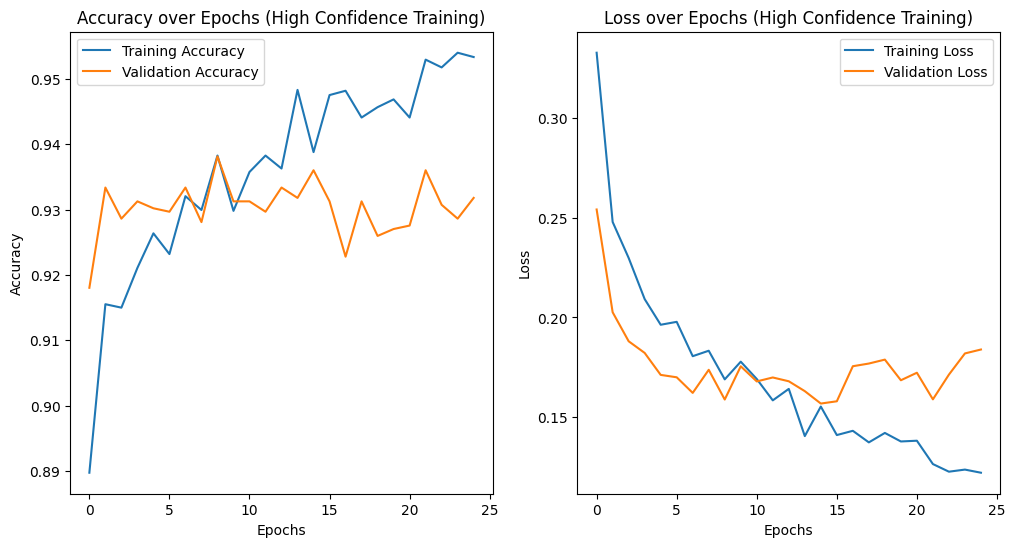

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels

# Step 1: Get predictions for the training data
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select the top 3800 high-confidence images per class
selected_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    top_images = disease_images.nlargest(3800, 'confidence')  # Select top 3800 by confidence
    selected_images.append(top_images)

selected_images = pd.concat(selected_images)

# Step 4: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying high-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with high-confidence images
high_confidence_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

high_confidence_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", high_confidence_train_generator.class_indices)
print("Number of training samples:", high_confidence_train_generator.samples)
print("Number of validation samples:", high_confidence_val_generator.samples)

# Retrain the model
history_high_confidence = model.fit(
    high_confidence_train_generator,
    epochs=25,
    validation_data=high_confidence_val_generator
)

# Save the updated model
model.save("lung_disease_model_high_confidence.h5")

# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_high_confidence.history['accuracy'], label='Training Accuracy')
plt.plot(history_high_confidence.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high_confidence.history['loss'], label='Training Loss')
plt.plot(history_high_confidence.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### First 3500 high confidence images in each class (Training from high confidence to low confidence images)

Found 14174 images belonging to 3 classes.
443/443 ━━━━━━━━━━━━━━━━━━━━ 186s 419ms/step


Copying high-confidence images: 100%|██████████| 10500/10500 [00:04<00:00, 2568.55it/s]


Found 9466 images belonging to 3 classes.
Found 2364 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 9466
Number of validation samples: 2364
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/296 ━━━━━━━━━━━━━━━━━━━━ 207s 689ms/step - accuracy: 0.9254 - loss: 0.1895 - val_accuracy: 0.9137 - val_loss: 0.2219
Epoch 2/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 165s 545ms/step - accuracy: 0.9337 - loss: 0.1795 - val_accuracy: 0.9040 - val_loss: 0.2542
Epoch 3/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 166s 548ms/step - accuracy: 0.9322 - loss: 0.1678 - val_accuracy: 0.8989 - val_loss: 0.2549
Epoch 4/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 165s 545ms/step - accuracy: 0.9318 - loss: 0.1732 - val_accuracy: 0.8951 - val_loss: 0.2586
Epoch 5/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 165s 546ms/step - accuracy: 0.9366 - loss: 0.1641 - val_accuracy: 0.9065 - val_loss: 0.2352
Epoch 6/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 165s 546ms/step - accuracy: 0.9423 - loss: 0.1599 - val_accuracy: 0.9086 - val_loss: 0.2346
Epoch 7/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 163s 541ms/step - accuracy: 0.9394 - loss: 0.1555 - val_accuracy: 0.8985 - val_loss: 0.2540
Epoch 8/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 165s 545ms/step - accuracy: 0.9401 - loss: 0.16

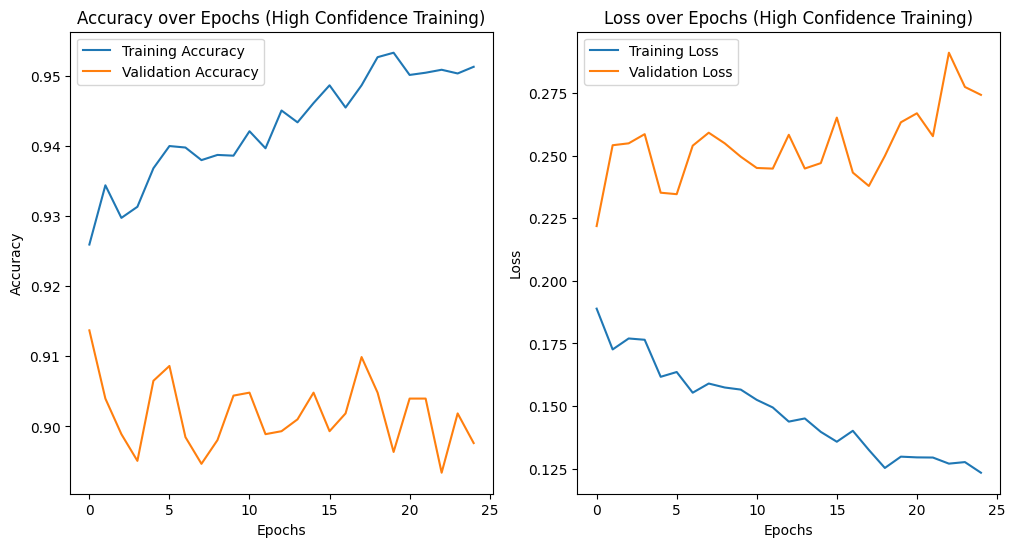

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels

# Step 1: Get predictions for the training data
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select the top 3500 high-confidence images per class
selected_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    top_images = disease_images.nlargest(3500, 'confidence')  # Select top 3500 by confidence
    selected_images.append(top_images)

selected_images = pd.concat(selected_images)

# Step 4: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying high-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with high-confidence images
high_confidence_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

high_confidence_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", high_confidence_train_generator.class_indices)
print("Number of training samples:", high_confidence_train_generator.samples)
print("Number of validation samples:", high_confidence_val_generator.samples)

# Retrain the model
history_high_confidence = model.fit(
    high_confidence_train_generator,
    epochs=25,
    validation_data=high_confidence_val_generator
)

# Save the updated model
model.save("lung_disease_model_high_confidence.h5")

# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_high_confidence.history['accuracy'], label='Training Accuracy')
plt.plot(history_high_confidence.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high_confidence.history['loss'], label='Training Loss')
plt.plot(history_high_confidence.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### First 3000 high confidence images in each class (Training from high confidence to low confidence images)

Found 14174 images belonging to 3 classes.
443/443 ━━━━━━━━━━━━━━━━━━━━ 187s 423ms/step


Copying high-confidence images: 100%|██████████| 9000/9000 [00:03<00:00, 2569.66it/s]


Found 9750 images belonging to 3 classes.
Found 2435 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 9750
Number of validation samples: 2435
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


305/305 ━━━━━━━━━━━━━━━━━━━━ 206s 666ms/step - accuracy: 0.9554 - loss: 0.1189 - val_accuracy: 0.8903 - val_loss: 0.3057
Epoch 2/25
305/305 ━━━━━━━━━━━━━━━━━━━━ 165s 529ms/step - accuracy: 0.9514 - loss: 0.1286 - val_accuracy: 0.8994 - val_loss: 0.2759
Epoch 3/25
305/305 ━━━━━━━━━━━━━━━━━━━━ 169s 544ms/step - accuracy: 0.9543 - loss: 0.1233 - val_accuracy: 0.8961 - val_loss: 0.2798
Epoch 4/25
305/305 ━━━━━━━━━━━━━━━━━━━━ 170s 547ms/step - accuracy: 0.9511 - loss: 0.1208 - val_accuracy: 0.8932 - val_loss: 0.3000
Epoch 5/25
305/305 ━━━━━━━━━━━━━━━━━━━━ 170s 546ms/step - accuracy: 0.9563 - loss: 0.1136 - val_accuracy: 0.8990 - val_loss: 0.2827
Epoch 6/25
305/305 ━━━━━━━━━━━━━━━━━━━━ 170s 546ms/step - accuracy: 0.9548 - loss: 0.1219 - val_accuracy: 0.9006 - val_loss: 0.2817
Epoch 7/25
305/305 ━━━━━━━━━━━━━━━━━━━━ 170s 546ms/step - accuracy: 0.9568 - loss: 0.1092 - val_accuracy: 0.8977 - val_loss: 0.2872
Epoch 8/25
305/305 ━━━━━━━━━━━━━━━━━━━━ 170s 546ms/step - accuracy: 0.9532 - loss: 0.11

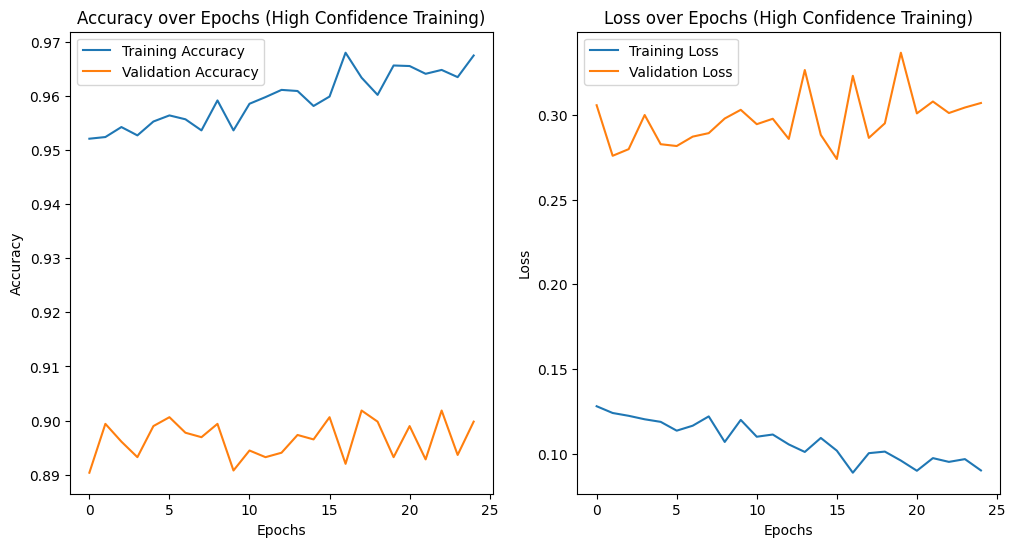

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels

# Step 1: Get predictions for the training data
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select the top 3000 high-confidence images per class
selected_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    top_images = disease_images.nlargest(3000, 'confidence')  # Select top 3000 by confidence
    selected_images.append(top_images)

selected_images = pd.concat(selected_images)

# Step 4: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying high-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with high-confidence images
high_confidence_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

high_confidence_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", high_confidence_train_generator.class_indices)
print("Number of training samples:", high_confidence_train_generator.samples)
print("Number of validation samples:", high_confidence_val_generator.samples)

# Retrain the model
history_high_confidence = model.fit(
    high_confidence_train_generator,
    epochs=25,
    validation_data=high_confidence_val_generator
)

# Save the updated model
model.save("lung_disease_model_high_confidence.h5")

# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_high_confidence.history['accuracy'], label='Training Accuracy')
plt.plot(history_high_confidence.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high_confidence.history['loss'], label='Training Loss')
plt.plot(history_high_confidence.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### First 2500 high confidence images in each class (Training from high confidence to low confidence images)

Found 14174 images belonging to 3 classes.
443/443 ━━━━━━━━━━━━━━━━━━━━ 187s 422ms/step


Copying high-confidence images: 100%|██████████| 7500/7500 [00:03<00:00, 2496.23it/s]


Found 9802 images belonging to 3 classes.
Found 2449 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 9802
Number of validation samples: 2449
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


307/307 ━━━━━━━━━━━━━━━━━━━━ 209s 672ms/step - accuracy: 0.9621 - loss: 0.0979 - val_accuracy: 0.8873 - val_loss: 0.3314
Epoch 2/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 170s 544ms/step - accuracy: 0.9678 - loss: 0.0838 - val_accuracy: 0.8975 - val_loss: 0.3203
Epoch 3/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 171s 547ms/step - accuracy: 0.9644 - loss: 0.0897 - val_accuracy: 0.8906 - val_loss: 0.3453
Epoch 4/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 170s 544ms/step - accuracy: 0.9680 - loss: 0.0831 - val_accuracy: 0.8979 - val_loss: 0.3383
Epoch 5/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 170s 543ms/step - accuracy: 0.9688 - loss: 0.0900 - val_accuracy: 0.8885 - val_loss: 0.3414
Epoch 6/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 170s 544ms/step - accuracy: 0.9655 - loss: 0.0866 - val_accuracy: 0.9036 - val_loss: 0.2985
Epoch 7/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 550ms/step - accuracy: 0.9696 - loss: 0.0825 - val_accuracy: 0.8971 - val_loss: 0.3256
Epoch 8/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 171s 547ms/step - accuracy: 0.9679 - loss: 0.08

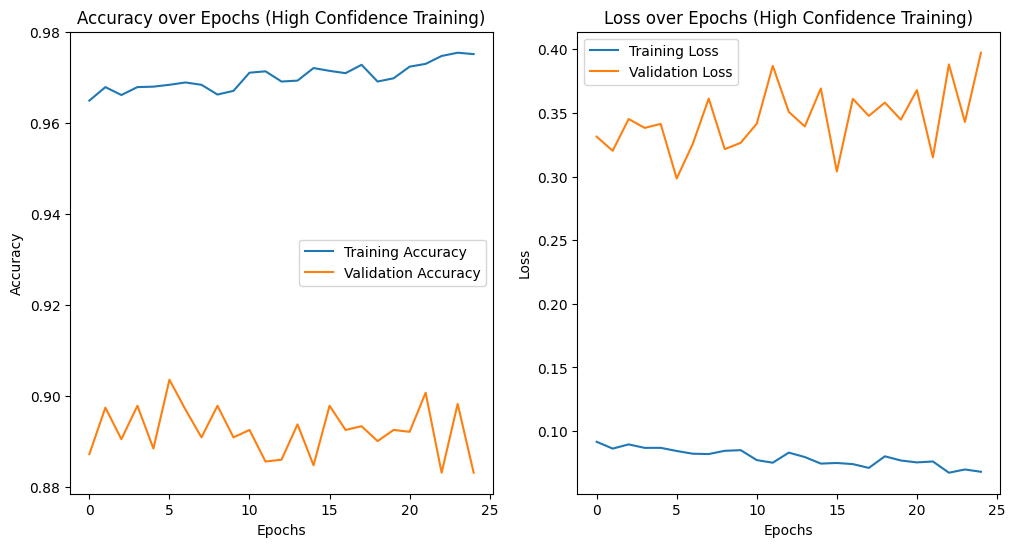

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels

# Step 1: Get predictions for the training data
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select the top 2500 high-confidence images per class
selected_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    top_images = disease_images.nlargest(2500, 'confidence')  # Select top 2500 by confidence
    selected_images.append(top_images)

selected_images = pd.concat(selected_images)

# Step 4: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying high-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with high-confidence images
high_confidence_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

high_confidence_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", high_confidence_train_generator.class_indices)
print("Number of training samples:", high_confidence_train_generator.samples)
print("Number of validation samples:", high_confidence_val_generator.samples)

# Retrain the model
history_high_confidence = model.fit(
    high_confidence_train_generator,
    epochs=25,
    validation_data=high_confidence_val_generator
)

# Save the updated model
model.save("lung_disease_model_high_confidence.h5")

# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_high_confidence.history['accuracy'], label='Training Accuracy')
plt.plot(history_high_confidence.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high_confidence.history['loss'], label='Training Loss')
plt.plot(history_high_confidence.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### First 2000 high confidence images in each class (Training from high confidence to low confidence images)

Found 14174 images belonging to 3 classes.
443/443 ━━━━━━━━━━━━━━━━━━━━ 188s 423ms/step


Copying high-confidence images: 100%|██████████| 6000/6000 [00:02<00:00, 2533.48it/s]


Found 9810 images belonging to 3 classes.
Found 2452 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 9810
Number of validation samples: 2452
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


307/307 ━━━━━━━━━━━━━━━━━━━━ 213s 685ms/step - accuracy: 0.9762 - loss: 0.0662 - val_accuracy: 0.8985 - val_loss: 0.3172
Epoch 2/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 171s 546ms/step - accuracy: 0.9739 - loss: 0.0682 - val_accuracy: 0.8944 - val_loss: 0.3622
Epoch 3/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 550ms/step - accuracy: 0.9759 - loss: 0.0627 - val_accuracy: 0.9033 - val_loss: 0.3324
Epoch 4/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 171s 545ms/step - accuracy: 0.9751 - loss: 0.0632 - val_accuracy: 0.8948 - val_loss: 0.3301
Epoch 5/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 548ms/step - accuracy: 0.9754 - loss: 0.0684 - val_accuracy: 0.8952 - val_loss: 0.3410
Epoch 6/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 171s 545ms/step - accuracy: 0.9762 - loss: 0.0647 - val_accuracy: 0.8903 - val_loss: 0.3474
Epoch 7/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 169s 541ms/step - accuracy: 0.9743 - loss: 0.0662 - val_accuracy: 0.8972 - val_loss: 0.3582
Epoch 8/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 168s 535ms/step - accuracy: 0.9767 - loss: 0.06

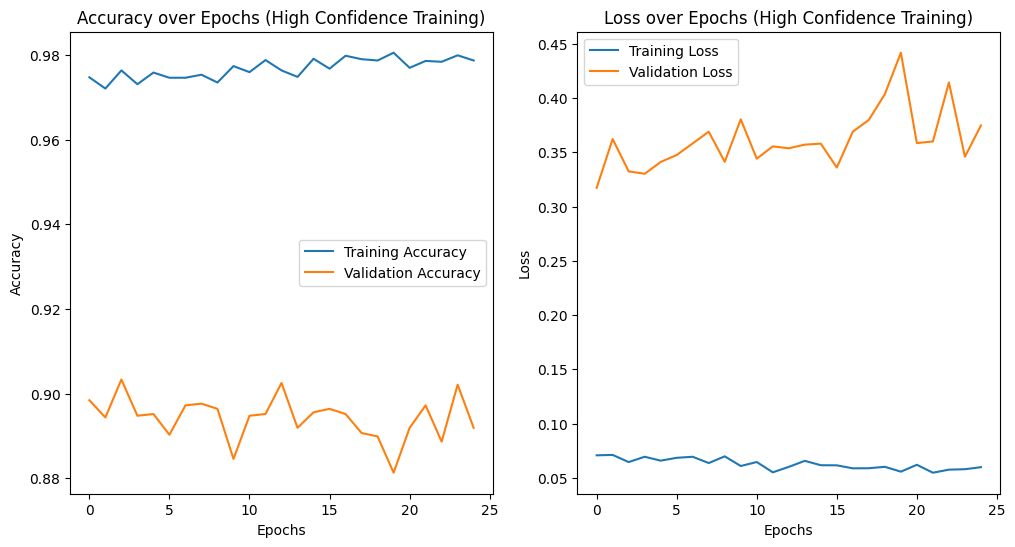

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels

# Step 1: Get predictions for the training data
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select the top 2000 high-confidence images per class
selected_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    top_images = disease_images.nlargest(2000, 'confidence')  # Select top 2000 by confidence
    selected_images.append(top_images)

selected_images = pd.concat(selected_images)

# Step 4: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying high-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with high-confidence images
high_confidence_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

high_confidence_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", high_confidence_train_generator.class_indices)
print("Number of training samples:", high_confidence_train_generator.samples)
print("Number of validation samples:", high_confidence_val_generator.samples)

# Retrain the model
history_high_confidence = model.fit(
    high_confidence_train_generator,
    epochs=25,
    validation_data=high_confidence_val_generator
)

# Save the updated model
model.save("lung_disease_model_high_confidence.h5")

# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_high_confidence.history['accuracy'], label='Training Accuracy')
plt.plot(history_high_confidence.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high_confidence.history['loss'], label='Training Loss')
plt.plot(history_high_confidence.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### First 1500 high confidence images in each class (Training from high confidence to low confidence images)

Found 14174 images belonging to 3 classes.
443/443 ━━━━━━━━━━━━━━━━━━━━ 185s 417ms/step


Copying high-confidence images: 100%|██████████| 4500/4500 [00:01<00:00, 2536.67it/s]


Found 9821 images belonging to 3 classes.
Found 2454 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 9821
Number of validation samples: 2454
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


307/307 ━━━━━━━━━━━━━━━━━━━━ 211s 677ms/step - accuracy: 0.9767 - loss: 0.0608 - val_accuracy: 0.8932 - val_loss: 0.3905
Epoch 2/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 169s 538ms/step - accuracy: 0.9801 - loss: 0.0520 - val_accuracy: 0.8839 - val_loss: 0.4117
Epoch 3/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 173s 552ms/step - accuracy: 0.9785 - loss: 0.0560 - val_accuracy: 0.8875 - val_loss: 0.4051
Epoch 4/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 548ms/step - accuracy: 0.9793 - loss: 0.0578 - val_accuracy: 0.8965 - val_loss: 0.3550
Epoch 5/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 168s 535ms/step - accuracy: 0.9777 - loss: 0.0562 - val_accuracy: 0.8932 - val_loss: 0.3941
Epoch 6/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 173s 550ms/step - accuracy: 0.9822 - loss: 0.0470 - val_accuracy: 0.8875 - val_loss: 0.3907
Epoch 7/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 549ms/step - accuracy: 0.9801 - loss: 0.0582 - val_accuracy: 0.8904 - val_loss: 0.3811
Epoch 8/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 549ms/step - accuracy: 0.9807 - loss: 0.05

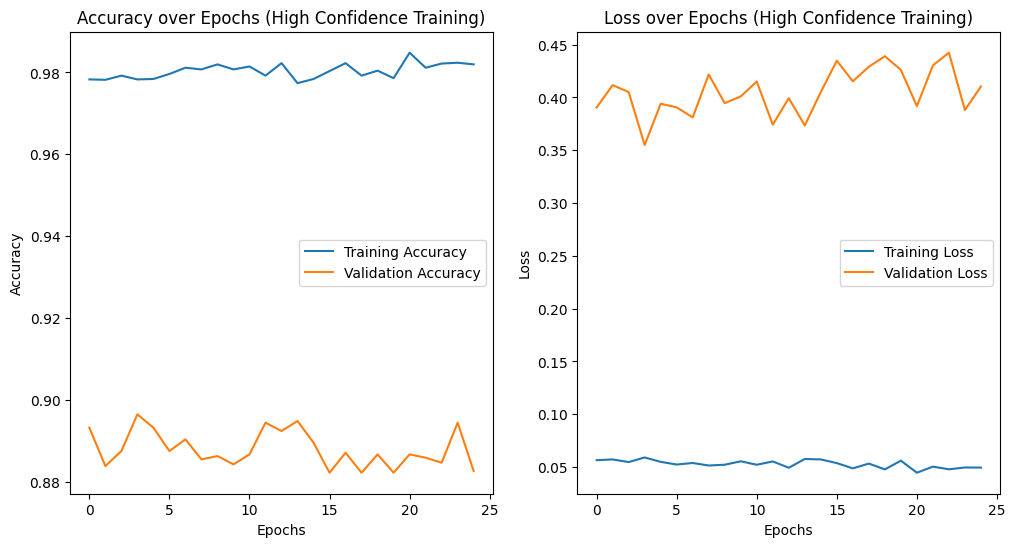

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels

# Step 1: Get predictions for the training data
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select the top 1500 high-confidence images per class
selected_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    top_images = disease_images.nlargest(1500, 'confidence')  # Select top 1500 by confidence
    selected_images.append(top_images)

selected_images = pd.concat(selected_images)

# Step 4: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying high-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with high-confidence images
high_confidence_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

high_confidence_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", high_confidence_train_generator.class_indices)
print("Number of training samples:", high_confidence_train_generator.samples)
print("Number of validation samples:", high_confidence_val_generator.samples)

# Retrain the model
history_high_confidence = model.fit(
    high_confidence_train_generator,
    epochs=25,
    validation_data=high_confidence_val_generator
)

# Save the updated model
model.save("lung_disease_model_high_confidence.h5")

# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_high_confidence.history['accuracy'], label='Training Accuracy')
plt.plot(history_high_confidence.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high_confidence.history['loss'], label='Training Loss')
plt.plot(history_high_confidence.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### First 1000 high confidence images in each class (Training from high confidence to low confidence images)

Found 14174 images belonging to 3 classes.
443/443 ━━━━━━━━━━━━━━━━━━━━ 192s 433ms/step


Copying high-confidence images: 100%|██████████| 3000/3000 [00:01<00:00, 2660.26it/s]


Found 9823 images belonging to 3 classes.
Found 2454 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 9823
Number of validation samples: 2454
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


307/307 ━━━━━━━━━━━━━━━━━━━━ 210s 674ms/step - accuracy: 0.9817 - loss: 0.0487 - val_accuracy: 0.8863 - val_loss: 0.4224
Epoch 2/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 170s 542ms/step - accuracy: 0.9801 - loss: 0.0545 - val_accuracy: 0.8904 - val_loss: 0.4333
Epoch 3/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 549ms/step - accuracy: 0.9824 - loss: 0.0470 - val_accuracy: 0.8871 - val_loss: 0.4123
Epoch 4/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 173s 549ms/step - accuracy: 0.9840 - loss: 0.0432 - val_accuracy: 0.8888 - val_loss: 0.4365
Epoch 5/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 549ms/step - accuracy: 0.9810 - loss: 0.0467 - val_accuracy: 0.8871 - val_loss: 0.4135
Epoch 6/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 170s 542ms/step - accuracy: 0.9830 - loss: 0.0502 - val_accuracy: 0.9006 - val_loss: 0.3967
Epoch 7/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 549ms/step - accuracy: 0.9843 - loss: 0.0416 - val_accuracy: 0.8928 - val_loss: 0.4013
Epoch 8/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 175s 558ms/step - accuracy: 0.9848 - loss: 0.04

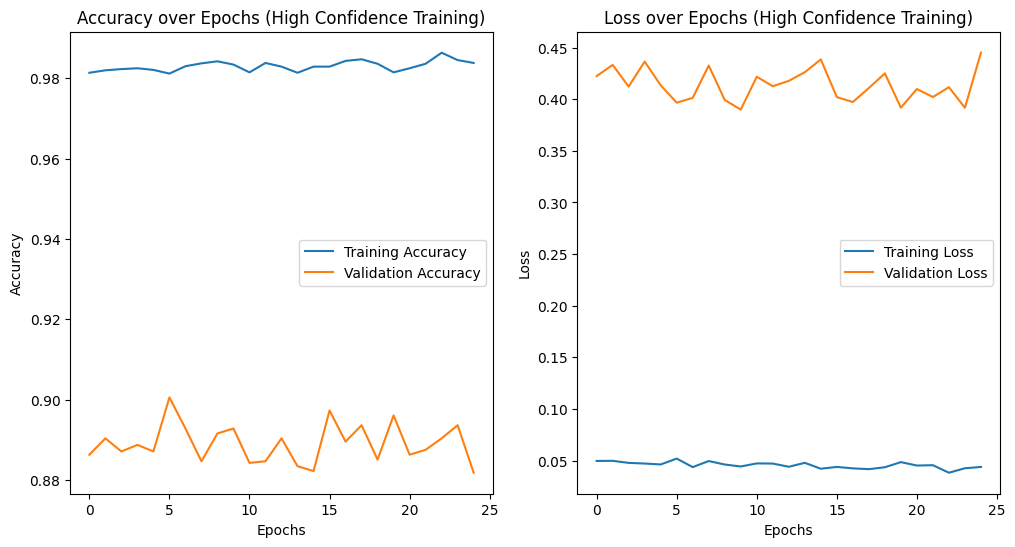

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels

# Step 1: Get predictions for the training data
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select the top 1000 high-confidence images per class
selected_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    top_images = disease_images.nlargest(1000, 'confidence')  # Select top 1000 by confidence
    selected_images.append(top_images)

selected_images = pd.concat(selected_images)

# Step 4: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying high-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with high-confidence images
high_confidence_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

high_confidence_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", high_confidence_train_generator.class_indices)
print("Number of training samples:", high_confidence_train_generator.samples)
print("Number of validation samples:", high_confidence_val_generator.samples)

# Retrain the model
history_high_confidence = model.fit(
    high_confidence_train_generator,
    epochs=25,
    validation_data=high_confidence_val_generator
)

# Save the updated model
model.save("lung_disease_model_high_confidence.h5")

# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_high_confidence.history['accuracy'], label='Training Accuracy')
plt.plot(history_high_confidence.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high_confidence.history['loss'], label='Training Loss')
plt.plot(history_high_confidence.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### First 3000 high confidence images in each class (Training from low confidence to high confidence images)

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels
# Step 1: Get predictions for the training data (same as before)
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select the bottom 3000 low-confidence images per class
selected_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    bottom_images = disease_images.nsmallest(3000, 'confidence')  # Select bottom 3000 by confidence (low-confidence)
    selected_images.append(bottom_images)

selected_images = pd.concat(selected_images)

# Step 4: Copy selected low-confidence images to a new directory
low_confidence_dir = "low_confidence_images"
os.makedirs(low_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying low-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(low_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with low-confidence images (first round of training)
low_confidence_train_generator = datagen.flow_from_directory(
    low_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

low_confidence_val_generator = datagen.flow_from_directory(
    low_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

# Retrain with low-confidence images
history_low_confidence = model.fit(
    low_confidence_train_generator,
    epochs=25,
    validation_data=low_confidence_val_generator
)

# Step 6: Save the model after low-confidence training
model.save("lung_disease_model_low_confidence.h5")

# Step 7: Select the next set of high-confidence images (next 3000 images per class)
next_high_confidence_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    next_high_images = disease_images.nlargest(3000, 'confidence').iloc[3000:]  # Skip the first 3000
    next_high_confidence_images.append(next_high_images)

next_high_confidence_images = pd.concat(next_high_confidence_images)

# Step 8: Copy selected high-confidence images to a new directory
mid_confidence_dir = "mid_confidence_images"
os.makedirs(mid_confidence_dir, exist_ok=True)

for _, row in tqdm(next_high_confidence_images.iterrows(), desc="Copying mid-confidence images", total=next_high_confidence_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(mid_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 9: Retrain the model with low + mid-confidence images
low_mid_confidence_train_generator = datagen.flow_from_directory(
    mid_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

low_mid_confidence_val_generator = datagen.flow_from_directory(
    mid_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

# Retrain with low + mid-confidence images
history_low_mid_confidence = model.fit(
    low_mid_confidence_train_generator,
    epochs=25,
    validation_data=low_mid_confidence_val_generator
)

# Step 10: Save the model after mid-confidence training
model.save("lung_disease_model_low_mid_confidence.h5")

# Step 11: Select the next high-confidence images (highest-confidence images for each class)
top_high_confidence_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    top_high_images = disease_images.nlargest(3000, 'confidence').iloc[6000:]  # Skip the first 6000
    top_high_confidence_images.append(top_high_images)

top_high_confidence_images = pd.concat(top_high_confidence_images)

# Step 12: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(top_high_confidence_images.iterrows(), desc="Copying high-confidence images", total=top_high_confidence_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 13: Retrain the model with all confidence images (low, mid, high confidence)
final_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

final_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

# Final retraining
history_final = model.fit(
    final_train_generator,
    epochs=25,
    validation_data=final_val_generator
)

# Save the final model
model.save("lung_disease_model_final.h5")


Found 14174 images belonging to 3 classes.
443/443 ━━━━━━━━━━━━━━━━━━━━ 193s 435ms/step


Copying low-confidence images: 100%|██████████| 9000/9000 [00:02<00:00, 3254.66it/s]


Found 7200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 135s 587ms/step - accuracy: 0.9103 - loss: 0.3318 - val_accuracy: 0.8583 - val_loss: 0.3953
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 136s 590ms/step - accuracy: 0.9045 - loss: 0.2567 - val_accuracy: 0.8739 - val_loss: 0.3435
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 130s 565ms/step - accuracy: 0.9145 - loss: 0.2428 - val_accuracy: 0.8689 - val_loss: 0.3319
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 129s 556ms/step - accuracy: 0.9207 - loss: 0.2185 - val_accuracy: 0.8650 - val_loss: 0.3292
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 127s 553ms/step - accuracy: 0.9174 - loss: 0.2112 - val_accuracy: 0.8739 - val_loss: 0.3105
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 128s 554ms/step - accuracy: 0.9225 - loss: 0.1966 - val_accuracy: 0.8739 - val_loss: 0.3054
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 128s 556ms/step - accuracy: 0.9224 - loss: 0.2121 - val_accuracy: 0.8728 - val_loss: 0.3258
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 129s 557ms/step - accuracy: 0.9245 - loss: 0.18

Copying mid-confidence images: 0it [00:00, ?it/s]

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


ValueError: Must provide at least one structure